<a href="https://colab.research.google.com/github/aulphin/FS_Attack-RISE/blob/main/FS_RISE_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/FS_Attack-main

/content/drive/.shortcut-targets-by-id/1nIMnV615KDFtD2I8g7QfyTPEC_6jkwNj/FS_Attack-main


In [6]:
case = '0'
img_path = 'tmp_image/'+case+'.jpeg'


RISE Method Implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.transform import resize
from torchvision import transforms


In [8]:
def load_img(path):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    x = transform(img).unsqueeze(0)
    return img, x

In [9]:
def generate_masks(N, s, p1):
    cell_size = torch.ceil(torch.tensor([224, 224]) / s).int()
    up_size = (s + 1) * cell_size

    grid = (torch.rand(N, s, s) < p1).float()
    masks = torch.empty((N, 224, 224))

    for i in tqdm(range(N), desc='Generating masks'):
        x = torch.randint(0, cell_size[0], (1,))
        y = torch.randint(0, cell_size[1], (1,))
        mask = torch.tensor(resize(grid[i].numpy(), up_size.numpy(), order=1, mode='reflect', anti_aliasing=False))
        masks[i, :, :] = mask[x:x + 224, y:y + 224]

    masks = masks.unsqueeze(1)  # Add a channel dimension
    return masks

In [10]:
class Model():
    def __init__(self, use_cuda=True):
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.model = resnet50(pretrained=True).to(self.device)
        self.model.eval()  # Set the model to evaluation mode
        self.input_size = (224, 224)
        self.preprocess = transforms.Compose([
            transforms.Resize(self.input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def run_on_batch(self, x):
        if isinstance(x, torch.Tensor):
            x = x.to(torch.float32).to(self.device)
        return self.model(x)


In [11]:
def explain(model, inp, masks):
    inp = inp.to(model.device)  # Move input tensor to the appropriate device
    masks = masks.to(model.device)  # Move masks to the appropriate device
    preds = []
    batch_size = 50  # Smaller batch size to reduce memory load
    N = masks.shape[0]

    masked = inp * masks  # Broadcasting input with masks

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        batch_masked = masked[i:min(i + batch_size, N)]
        preds.append(model.run_on_batch(batch_masked).to(model.device).cpu().detach())

        # Free up memory
        del batch_masked

    preds = torch.cat(preds).to(model.device)  # Ensure preds are on the same device
    sal = preds.T.matmul(masks.view(N, -1)).view(-1, 224, 224)
    sal = sal / N / masks.mean()
    return sal


In [12]:
# Trying to simplify get_expl function for easily call inside the updating of loss function
# Load the model
model = Model()
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(N, s, p1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]
Generating masks: 100%|██████████| 2000/2000 [00:04<00:00, 418.70it/s]


In [13]:
def get_expl(model, img_1, method='RISE'):
    img_1 = img_1.to(model.device)  # Move input tensor to the appropriate device

    sal = explain(model, img_1, masks)
    # Assuming the model predicts a class_idx, we select the index of the highest predicted class
    preds = model.run_on_batch(img_1)
    class_idx = torch.argmax(preds)
    adv_acc = preds  # Keep all predictions, not just the highest one
    adv_expl = sal[class_idx]
    return adv_expl, adv_acc, class_idx

In [14]:
img, im_orig = load_img(img_path)

In [15]:
# Get explanations using RISE (for original)
orig_expl, orig_acc, class_idx = get_expl(model, im_orig, method='RISE')


Explaining: 100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


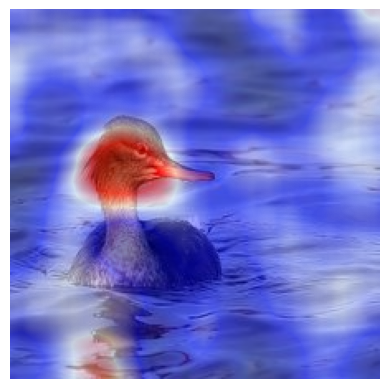

In [16]:
# Display the original image
plt.imshow(img)
# Overlay the saliency map with transparency
plt.imshow(orig_expl.squeeze().cpu(), cmap='seismic', alpha=0.5)  # Display the saliency map
plt.axis('off')  # Remove axis
plt.show()  # Show the plot

update in function

idea-2

Start Attack

In [86]:
# Clone the tensor
x_adv = im_orig.clone()

In [87]:
from nn.utils import get_center_attack_matrix

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
lr = 0.0002
# target attack
target_mtx = get_center_attack_matrix(200, 200, 35, orig_expl, 224)
target_mtx_torch = torch.tensor(target_mtx)
target_mtx_torch = target_mtx_torch.view(1,224,224)
target_mtx_torch = target_mtx_torch.to(device)
target_mtx_torch = target_mtx_torch.float()

optimizer = torch.optim.Adam([x_adv], lr=lr)


In [90]:
import numpy as np
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])

In [91]:
import torch
import torch.nn.functional as F
import numpy as np
from nn.utils import clamp

# Initialize variables
mode_2_loss = False
total_loss_list = []
L1_score, L2_score, L3_score, L4_score, L5_score = [], [], [], [], []
epoch_exp = []
EARLY_STOP = 0

In [93]:
# Use the run_on_batch method with the correctly shaped tensor
predictions = model.run_on_batch(im_orig)
# Get the predicted class index
_, predicted_class = torch.max(predictions, 1)  # Get the index of the max score

print(f'Predicted class index: {predicted_class.item()}')


Predicted class index: 98


In [74]:
# Compute the class index of the output
orig_class_idx = torch.argmax(predictions)
print(orig_class_idx)

tensor(98, device='cuda:0')


Devugging line by line

In [75]:
output = model.run_on_batch(x_adv)

In [26]:
sal = explain(model, x_adv, masks)
adv_expl = sal[class_idx]


Explaining: 100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


In [27]:
# Assuming you want to clamp the saliency map between 0 and 1
adv_expl = torch.clamp(adv_expl, -1, 1)

In [28]:
adv_expl = adv_expl.unsqueeze(0)

In [29]:
# Compute the center loss
center_loss = F.mse_loss(adv_expl, target_mtx_torch)
print(center_loss)


tensor(357.9429, device='cuda:0')


In [30]:
# Compute the output loss
output_loss = F.cross_entropy(output, torch.tensor([orig_class_idx]).to(output.device))
print(output_loss)

tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)


In [31]:
# # compute total loss
# prefactors = [1e4, 1e10, 1e-4] # 4 10 -4
# total_loss = prefactors[0]*output_loss + prefactors[1]*center_loss
# print(total_loss)

In [32]:
total_loss = output_loss + center_loss
print(total_loss)

tensor(357.9432, device='cuda:0', grad_fn=<AddBackward0>)


Performing Attack and generating x_adversarial image

In [62]:
# num_iter = 4
# epoch_exp = []
# EARLY_STOP = 0
# for i in range(num_iter):
#     optimizer.zero_grad()

#     output = model.run_on_batch(x_adv)


#     sal = explain(model, x_adv, masks)
#     adv_expl = sal[class_idx]

#     adv_expl = torch.clamp(adv_expl, -1, 1)

#     adv_expl = adv_expl.unsqueeze(0)

#     # Compute the center loss
#     center_loss = F.mse_loss(adv_expl, target_mtx_torch)
#     print(center_loss)

#     # Compute the output loss
#     output_loss = F.cross_entropy(output, torch.tensor([orig_class_idx]).to(output.device))
#     print(output_loss)

#     total_loss = output_loss + center_loss
#     print(total_loss)

#     x_tmp = x_adv

#     # Backpropagate the total loss
#     total_loss.backward()

#     # Update the adversarial image
#     optimizer.step()

#     # Clamp the adversarial image to ensure it's within the valid range
#     #x_adv.data = clamp(x_adv.data, 0,1)

#     # Check if the class index has changed
#     if class_idx != orig_class_idx:
#        print(i,'early done')
#        early_stop_epoch = i
#        if EARLY_STOP == True:
#             x_adv = x_tmp
#             break

# # Append the total loss to the list
# total_loss_list.append(total_loss.item())

# # Print the total loss at every 100 iterations
# if i % 100 == 0:
#     print(f"Iteration {i}, Total Loss: {total_loss.item(), center_loss(), output_loss()}")
#     epoch_exp.append(adv_expl)



In [94]:
num_iter = 3
for i in range(num_iter):
    optimizer.zero_grad()

    output = model.run_on_batch(x_adv)

    #debug
    adv_class_idx = torch.argmax(output)
    print(adv_class_idx)

    sal = explain(model, x_adv, masks)
    adv_expl = sal[class_idx]

    adv_expl = torch.clamp(adv_expl, -1, 1)

    adv_expl = adv_expl.unsqueeze(0)

    # Compute the center loss
    center_loss = F.mse_loss(adv_expl, target_mtx_torch)
    print(center_loss)

    # Compute the output loss
    output_loss = F.cross_entropy(output, torch.tensor([orig_class_idx]).to(output.device))
    print(output_loss)

    total_loss = output_loss + center_loss
    print(total_loss)

    # Backpropagate the total loss
    total_loss.backward()

    # Update the adversarial image
    optimizer.step()

    # Clamp the adversarial image to ensure it's within the valid range
    x_adv.data = torch.clamp(x_adv.data, 0, 1)

    # Check if the class index has changed
    if class_idx != orig_class_idx:
        print(i, 'early done')
        early_stop_epoch = i
        if EARLY_STOP == True:
            break
    x_adv.data = clamp(x_adv.data, data_mean, data_std)
    # Print the total loss at every 100 iterations
    if i % 100 == 0:
        print(f"Iteration {i}, Total Loss: {total_loss.item()}")
        epoch_exp.append(adv_expl)

tensor(98, device='cuda:0')


Explaining: 100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


tensor(357.9429, device='cuda:0')
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(357.9432, device='cuda:0', grad_fn=<AddBackward0>)
0 early done
Iteration 0, Total Loss: 357.9432373046875
tensor(141, device='cuda:0')


Explaining: 100%|██████████| 40/40 [00:05<00:00,  7.51it/s]


tensor(357.9429, device='cuda:0')
tensor(1.5474, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(359.4903, device='cuda:0', grad_fn=<AddBackward0>)
1 early done
tensor(141, device='cuda:0')


Explaining: 100%|██████████| 40/40 [00:05<00:00,  7.50it/s]


tensor(357.9429, device='cuda:0')
tensor(1.5474, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(359.4903, device='cuda:0', grad_fn=<AddBackward0>)
2 early done


Verify Adversarial image is generated or not

In [79]:
predictions = model.run_on_batch(x_adv)

In [80]:
# Compute the class index of the output
adv_class_idx = torch.argmax(predictions)
print(adv_class_idx)

tensor(141, device='cuda:0')


In [81]:
sal = explain(model, x_adv, masks)
adv_expl = sal[class_idx]

Explaining: 100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


In [84]:
# Display the Adversarial image after attack
plt.imshow(img)
# Overlay the saliency map with transparency
plt.imshow(adv_expl.squeeze().cpu(), cmap='seismic', alpha=0.5)  # Display the saliency map
plt.axis('off')  # Remove axis
plt.show()  # Show the plot